In [41]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [361]:
### Helper functions

def sum_of_squares(Xs):
    return sum(map(lambda k: k**2, Xs))

# Plot specified function in 3D space
def plot_function(function, ranges):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Prepare input data
    X1 = np.linspace(ranges[0], ranges[1], 100)
    X2 = np.linspace(ranges[0], ranges[1], 100)
    
    X1, X2 = np.meshgrid(X1, X2)
    Y = function([X1, X2])

    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap=plt.cm.PRGn)

### Functions of N variables (Xs) and ranges

# Sphere function, global minimum at X=(0,...,0)
sphere_function_range = [-100, 100]

def sphere_function(Xs):
    return np.fabs(sum_of_squares(Xs))


# Ackley function, global minimum at X=(0,...,0)
ackley_function_range = [-32.768, 32.768]

def ackley_function(Xs):
    a, b, c, d = 20, 0.2, 2 * math.pi, len(Xs)
    result = -a * np.exp(-b * np.sqrt((1 / d) * sum_of_squares(Xs))) \
             - np.exp((1 / d) * sum(map(lambda k: np.cos(c * k), Xs))) \
             + a + np.e
    return np.fabs(result)


# Griewank function, global minimum at X=(0,...,0) TODO
griewank_function_range = [-10, 10]

def griewank_function(Xs):
    result = sum(map(lambda k: k**2 / 4_000, Xs)) \
             - np.prod([(np.cos(Xs[i]) / np.sqrt(i + 1)) for i in range(len(Xs))]) \
             + 1
    return np.fabs(result)


# Rastrigin function, global minimum at X=(0,...,0)
rastrigin_function_range = [-5.12, 5.12]

def rastrigin_function(Xs):
    d = len(Xs)
    return 10 * d + sum(map(lambda k: (k**2 - 10 * np.cos(2 * math.pi * k)), Xs))


# Rosenbrock function, global minimum at X=(1,...,1)
rosenbrock_function_range = [-5, 10]

def rosenbrock_function(Xs):
    Xs_pairs = list(zip(Xs, Xs[1:]))
    return sum(map(lambda pair: 100 * (pair[1] - pair[0]**2)**2 + (pair[0] - 1)**2, Xs_pairs))

# Visualization
def visualize_results(nests):
    x = [nest['Xs'][0] for nest in nests]
    y = [nest['Xs'][1] for nest in nests]
    plt.plot(x, y, 'go')
    plt.axis([
        sphere_function_range[0],
        sphere_function_range[1],
        sphere_function_range[0],
        sphere_function_range[1],
    ])
    plt.show()

# Cuckoo search algorithm

def get_levy(t, levy_flight_lambda):
    return math.pow(t, - levy_flight_lambda)
  

def cuckoo_search(
        function, ranges, dimensions_count,
        cuckoo_count, nest_count,
        lambda_range=(1, 3),
        alpha_range=(0.1, 5.0),
        P_alpha=0.1,
        Levy_t=50,
        max_generation=1000,
        visualize=False,
        visualize_step=100):
    def Xs_random():
        return [random.uniform(ranges[0], ranges[1]) for i in range(dimensions_count)]
    # Place initial nests randomly
    nests_Xs = [Xs_random() for j in range(nest_count)]
    # Generate population
    nests = [{
        'fitness': function(Xs),
        'Xs': Xs
    } for Xs in nests_Xs]
    # Create cuckoos and assign them random nests
    cuckoos = [{
        'nest': nests[random.randint(0, len(nests) - 1)]
    } for i in range(cuckoo_count)]
    
    for t in range(max_generation):
        cuckoos = sorted(cuckoos, key=lambda cuckoo: cuckoo['nest']['fitness'], reverse=True)
        for (i, cuckoo) in enumerate(cuckoos):
            # Calculate lambda value by (2)
            cuckoo_lambda = lambda_range[1] - (i + 1) * (lambda_range[1] - lambda_range[0]) / (cuckoo_count - 1)
            # Calculate alpha value by (3)
            k = random.uniform(-1, 1)
            cuckoo_alpha = alpha_range[1] * (k * np.sqrt(alpha_range[0] / alpha_range[1])) ** (t + 1)
            # Calculate coordinates of new nest
            Xs_new = list(map(lambda x: x + cuckoo_alpha * get_levy(Levy_t, cuckoo_lambda), cuckoo['nest']['Xs']))
            # Assign the new nest to cuckoo, evaluate fitness
            cuckoo_new_nest = {
                'fitness': function(Xs_new),
                'Xs': Xs_new
            }
            # Choose nest among available randomly
            random_nest_index = random.randint(0, len(nests) - 1)
            if cuckoo['nest']['fitness'] < nests[random_nest_index]['fitness']:
                # Replace nest by a new solution
                cuckoo['nest'] = cuckoo_new_nest
                nests[random_nest_index] = cuckoo['nest']
        # Remove P_alpha worst nests, build new ones in place of them
        nests = sorted(nests, key=lambda nest: nest['fitness'], reverse=True)
        for i in range(math.floor(len(nests) * P_alpha)):
            Xs_new = Xs_random()
            nests[i] = {
                'fitness': function(Xs_new),
                'Xs': Xs_new
            }
        if visualize and t % visualize_step == 0:
            visualize_results(nests)
    
    results = list(map(lambda nest: nest['Xs'], sorted(nests, key = lambda nest: nest['fitness'])))
    
    return results

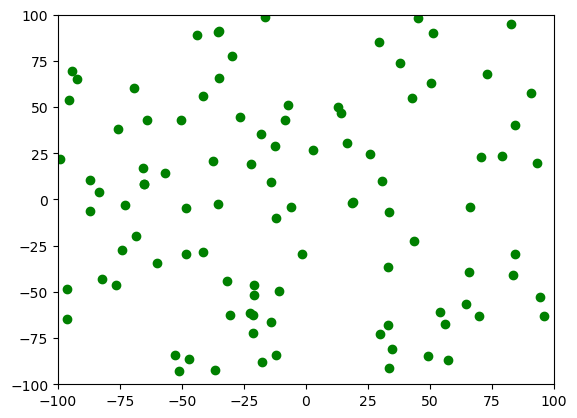

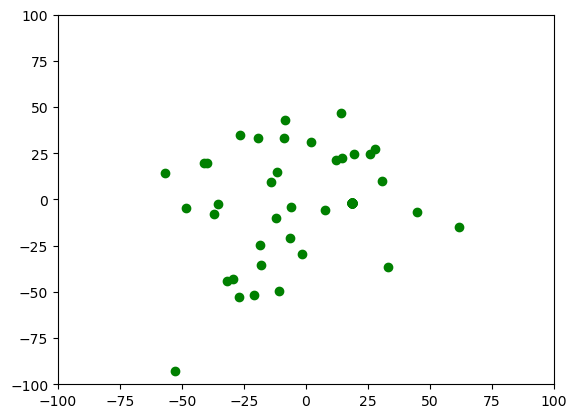

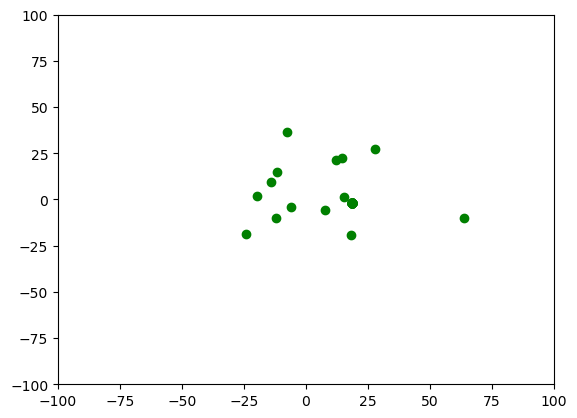

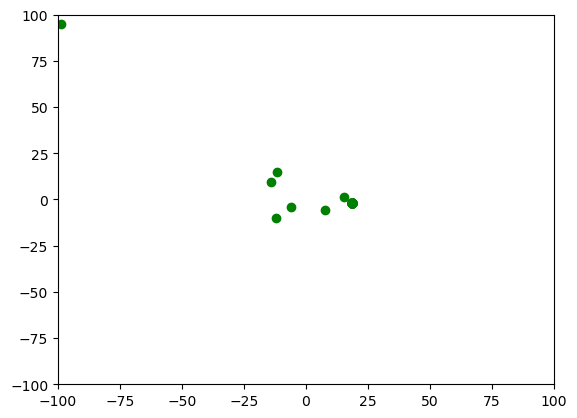

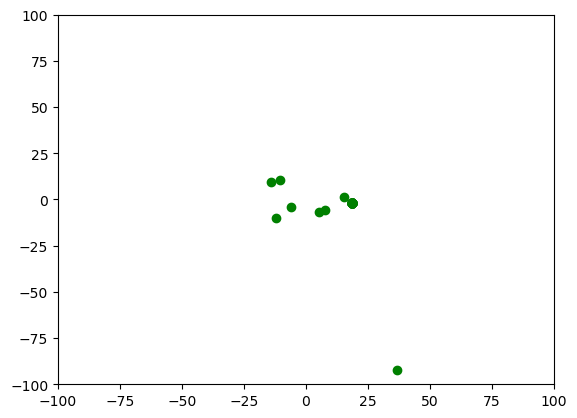

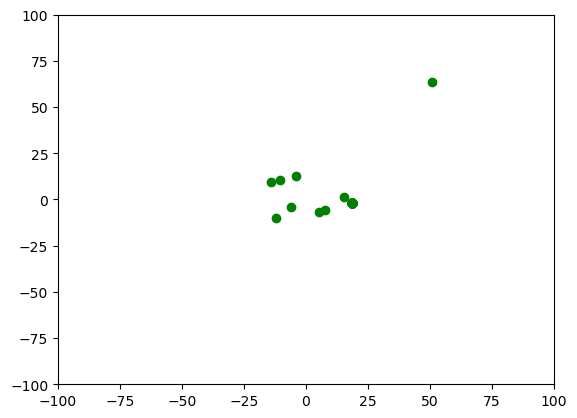

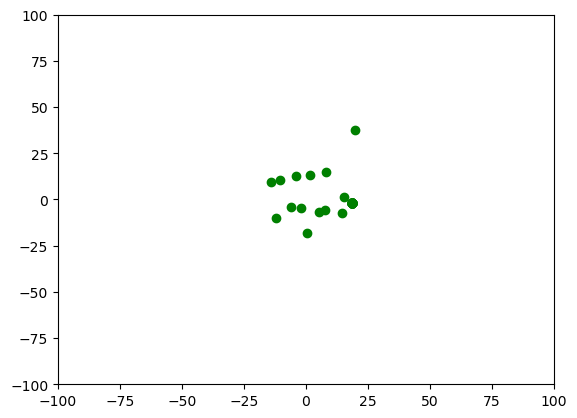

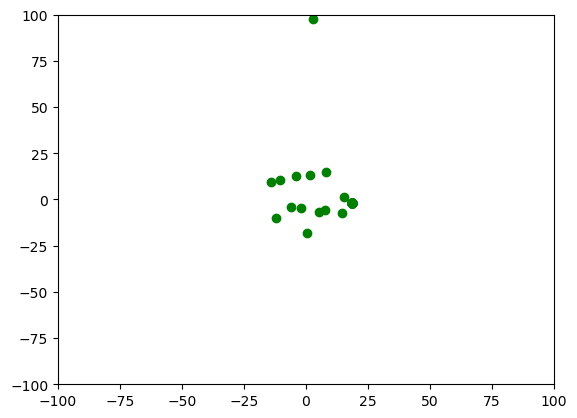

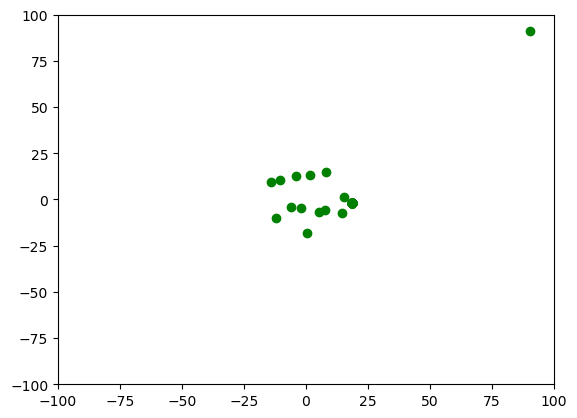

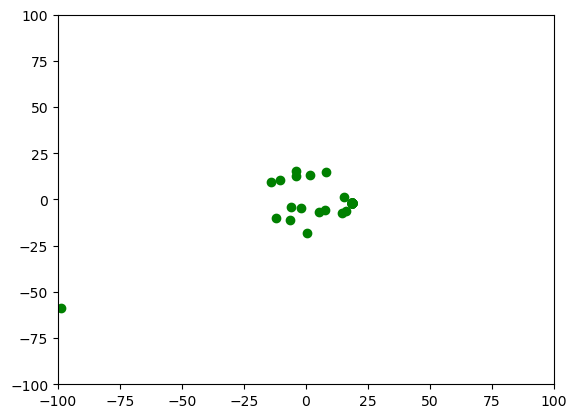

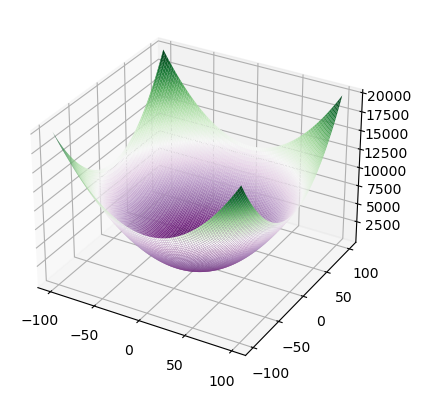

In [326]:
# Sphere function (in 3D space for visualization)

results = cuckoo_search(
    function=sphere_function,
    ranges=sphere_function_range,
    dimensions_count=2,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    visualize=True)

plot_function(sphere_function, sphere_function_range)

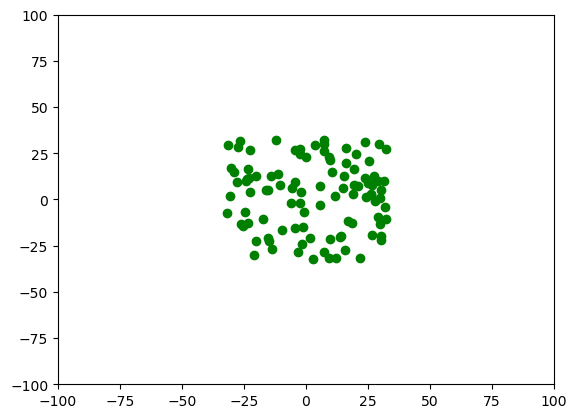

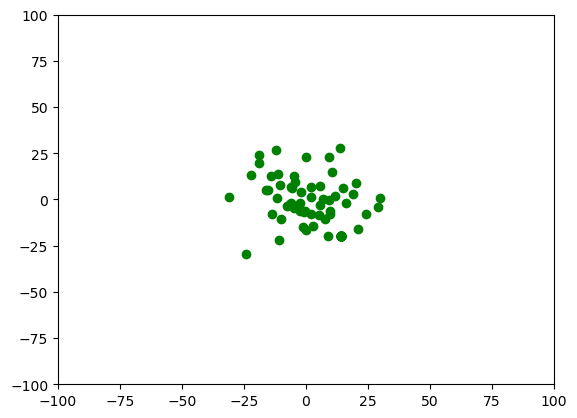

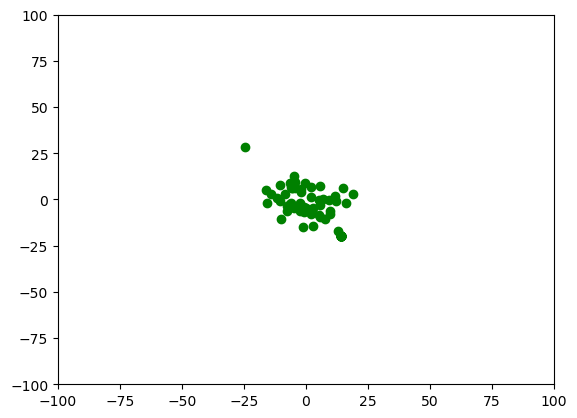

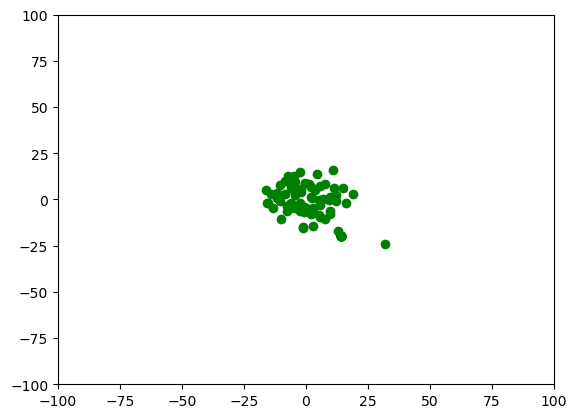

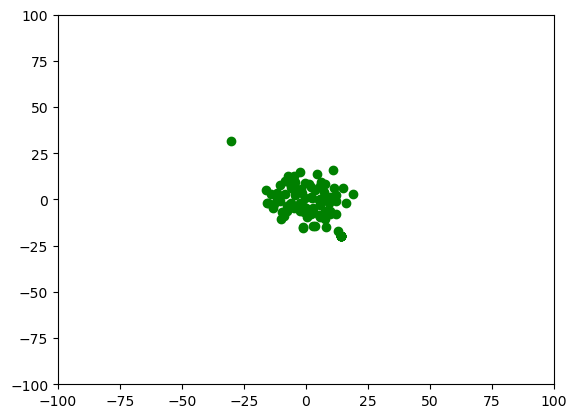

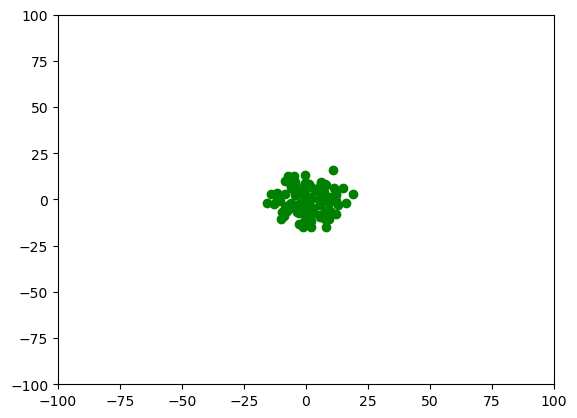

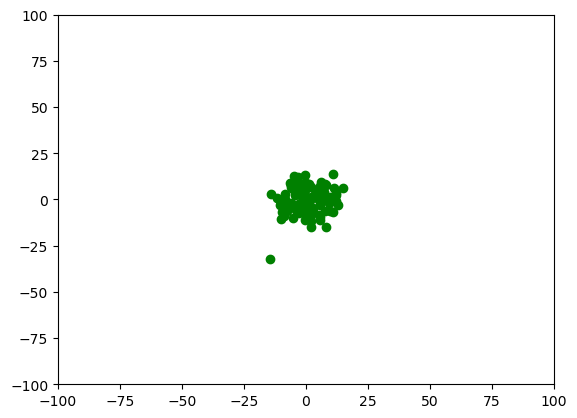

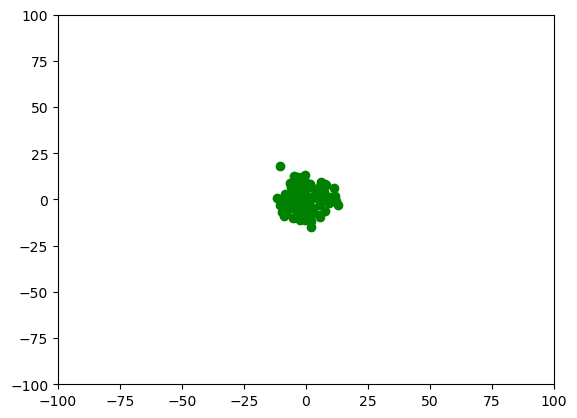

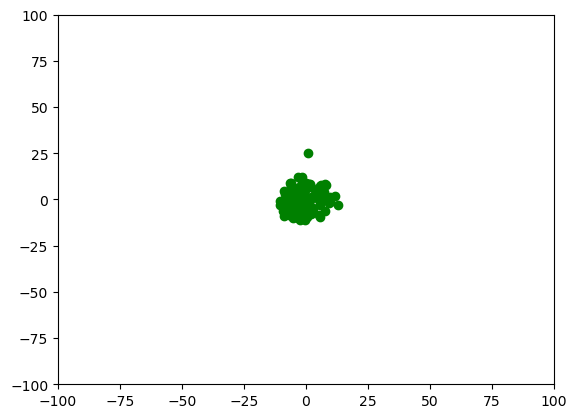

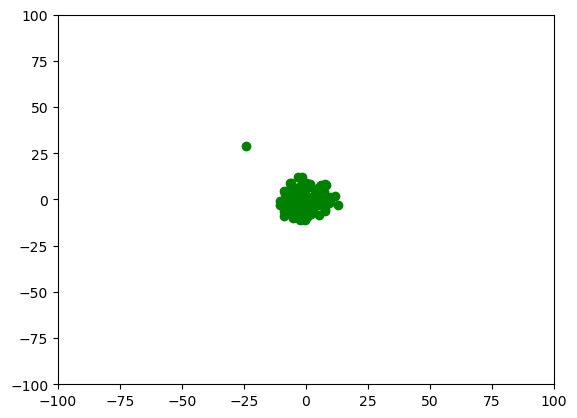

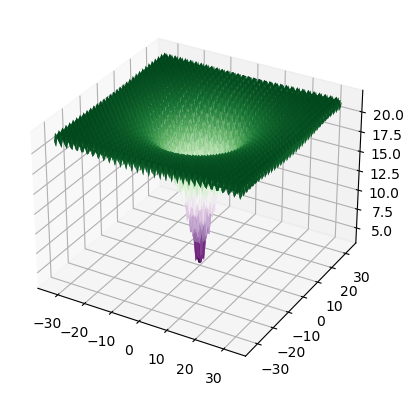

In [327]:
# Ackley function (in 3D space for visualization)

results = cuckoo_search(
    function=ackley_function,
    ranges=ackley_function_range,
    dimensions_count=2,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    visualize=True)

plot_function(ackley_function, ackley_function_range)


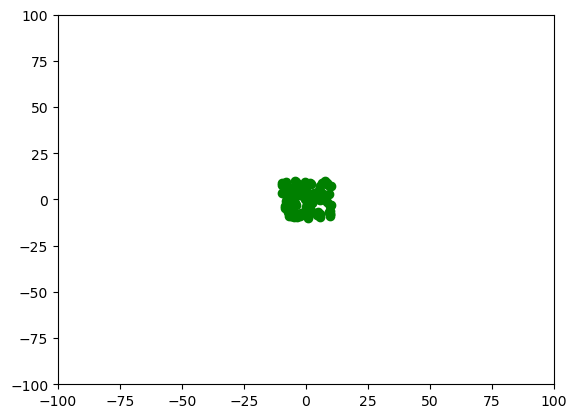

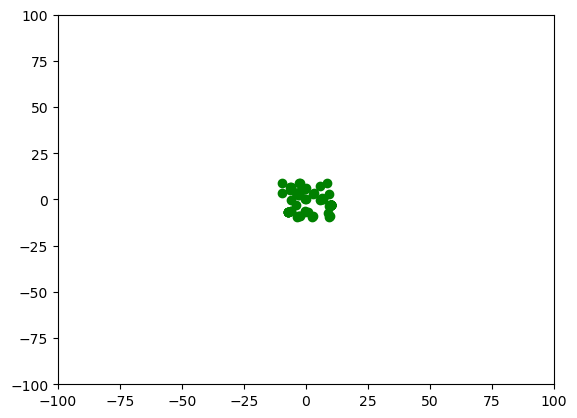

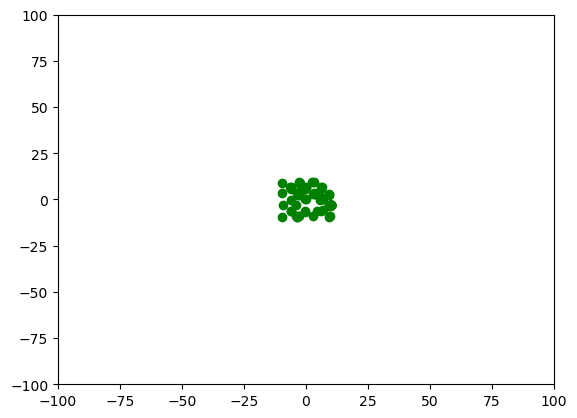

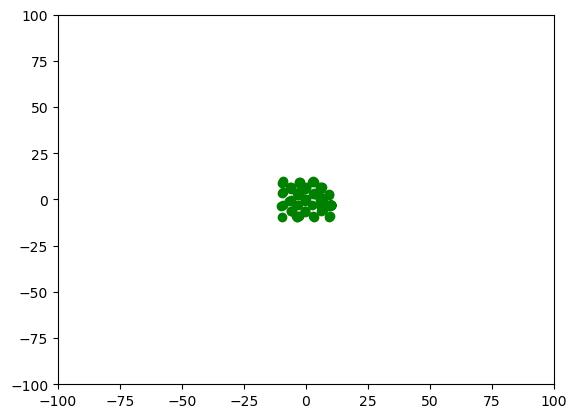

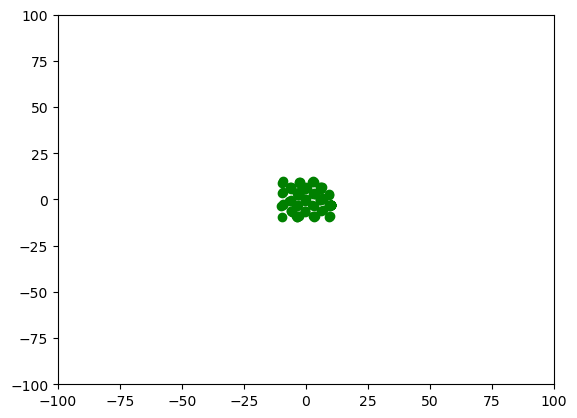

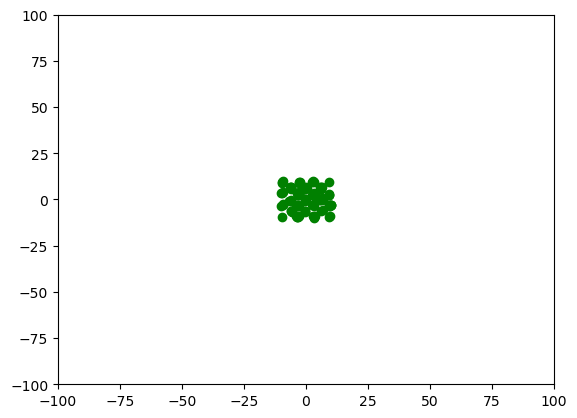

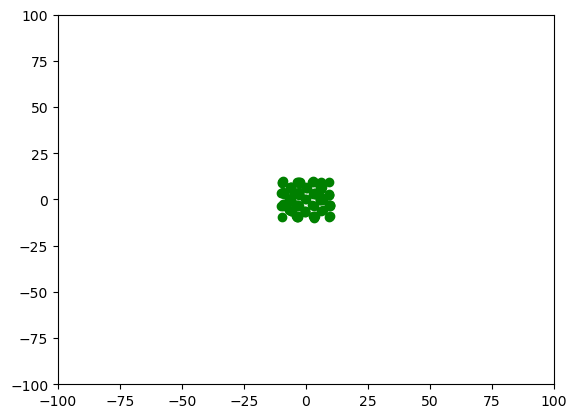

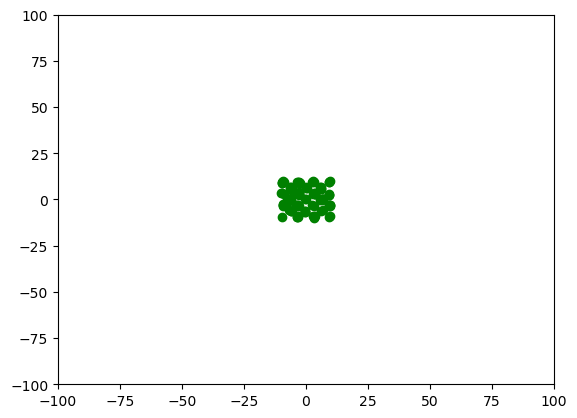

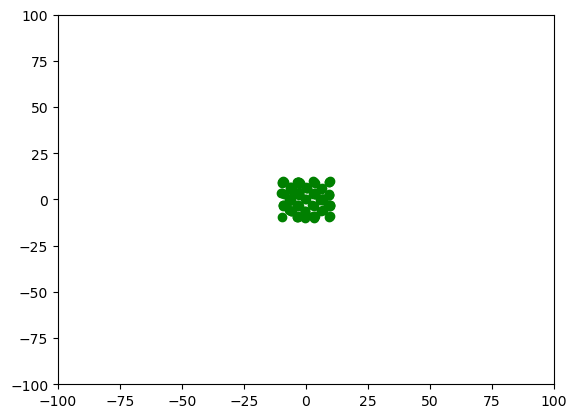

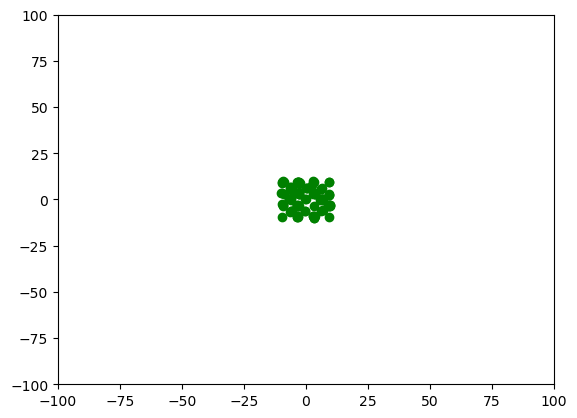

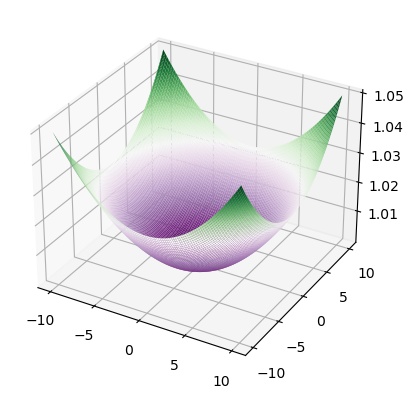

In [331]:
# Griewank function (in 3D space for visualization)

results = cuckoo_search(
    function=griewank_function,
    ranges=griewank_function_range,
    dimensions_count=2,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    visualize=True)

plot_function(griewank_function, griewank_function_range)

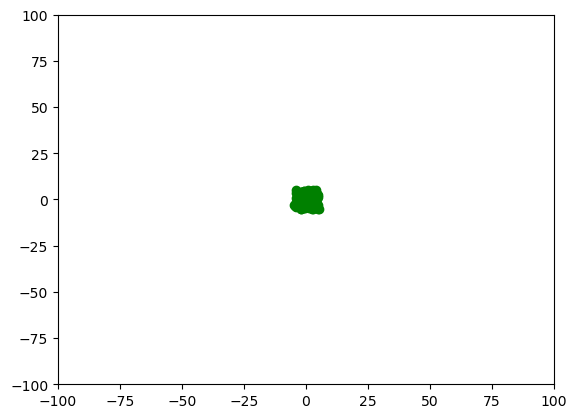

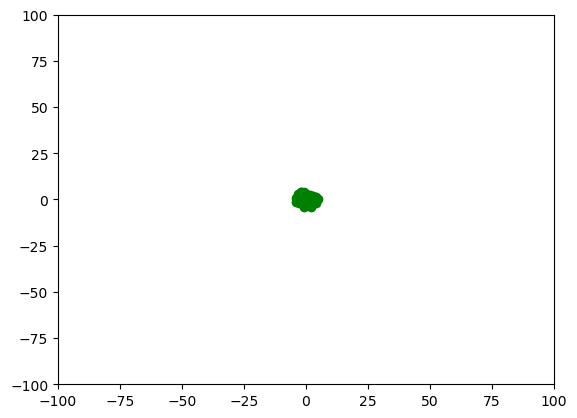

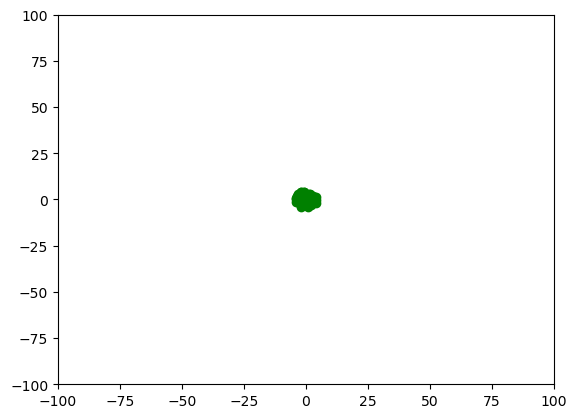

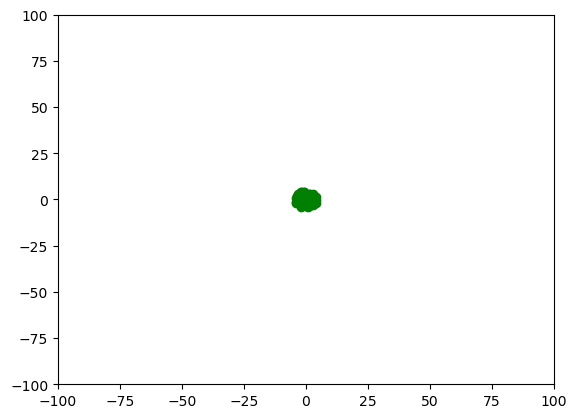

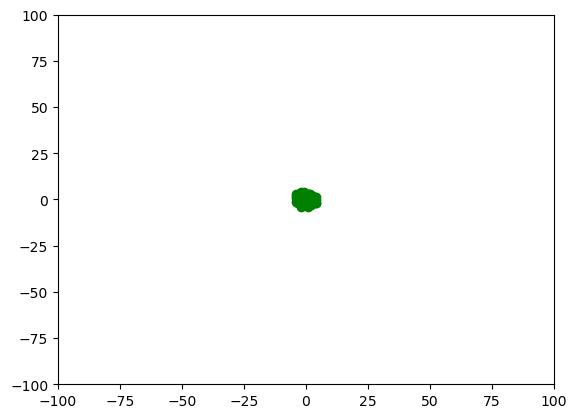

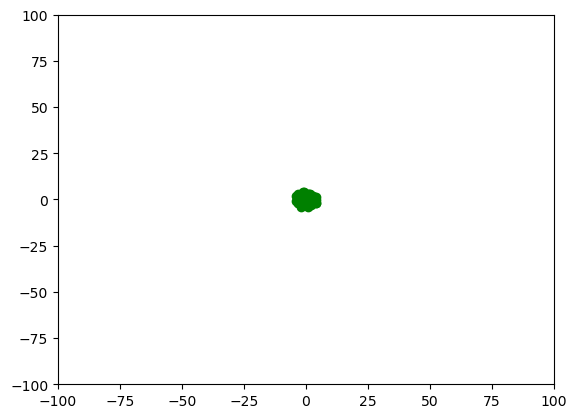

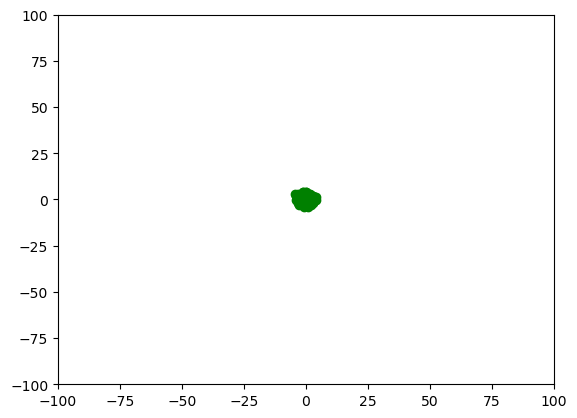

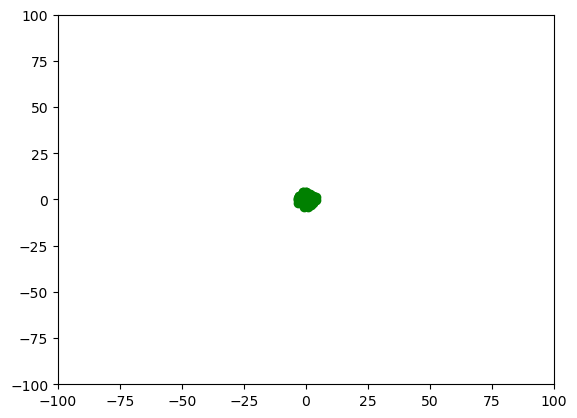

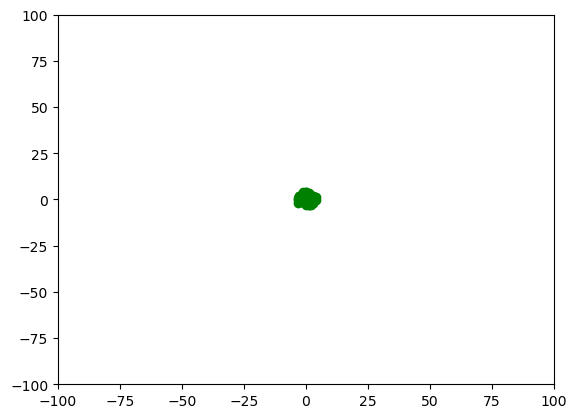

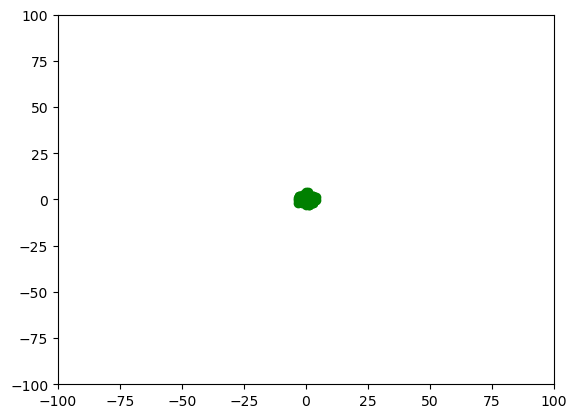

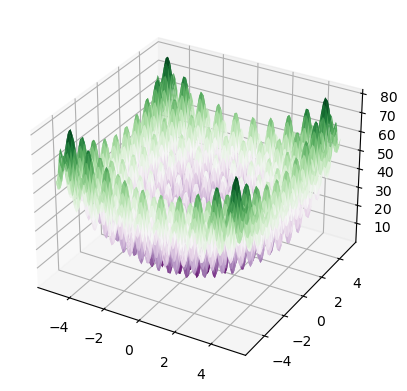

In [353]:
# Rastrigin function (in 3D space for visualization)

results = cuckoo_search(
    function=rastrigin_function,
    ranges=rastrigin_function_range,
    dimensions_count=2,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    visualize=True)

plot_function(rastrigin_function, rastrigin_function_range)

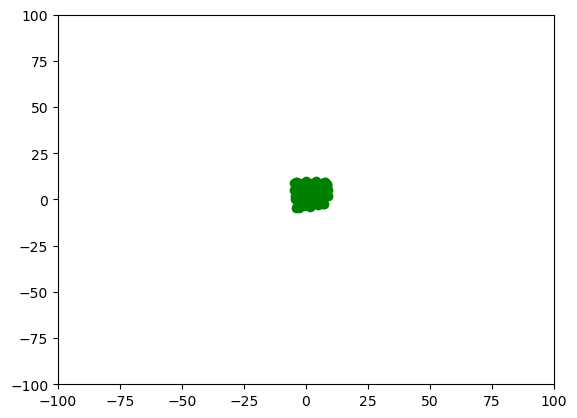

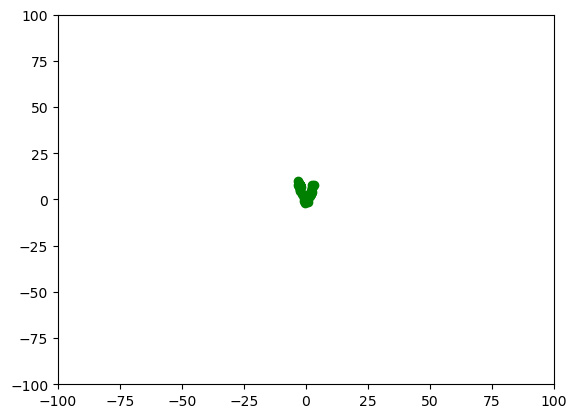

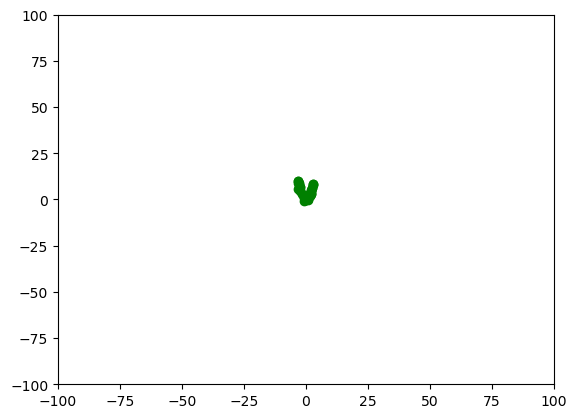

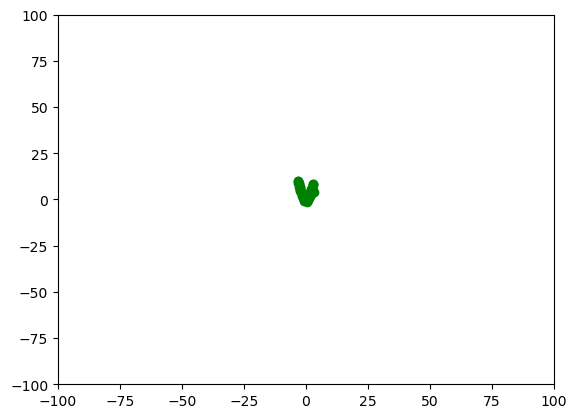

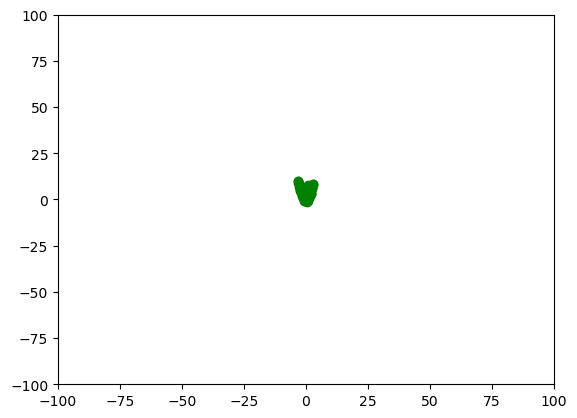

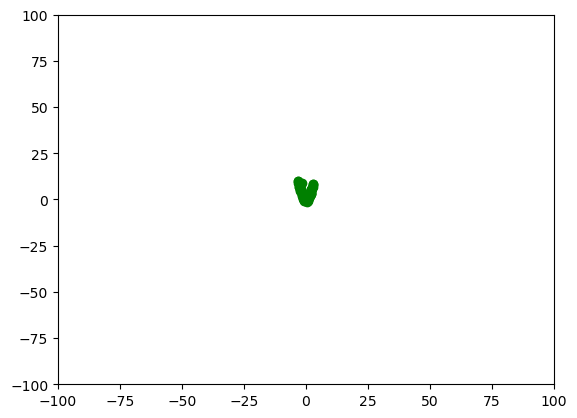

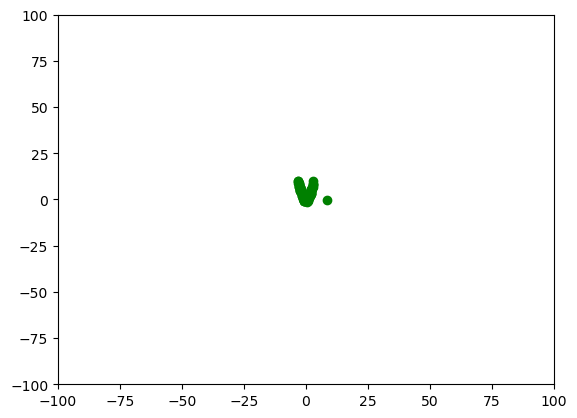

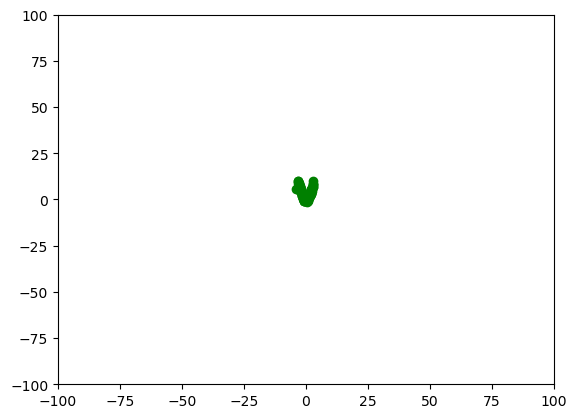

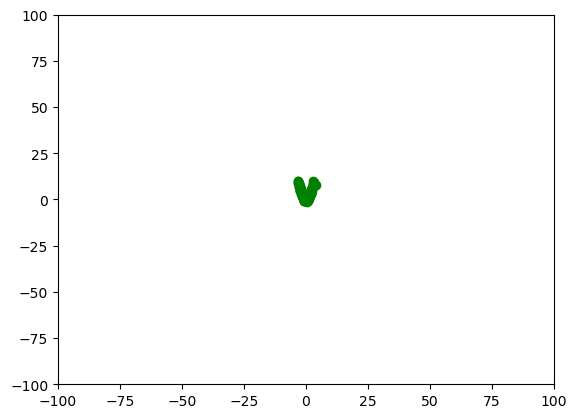

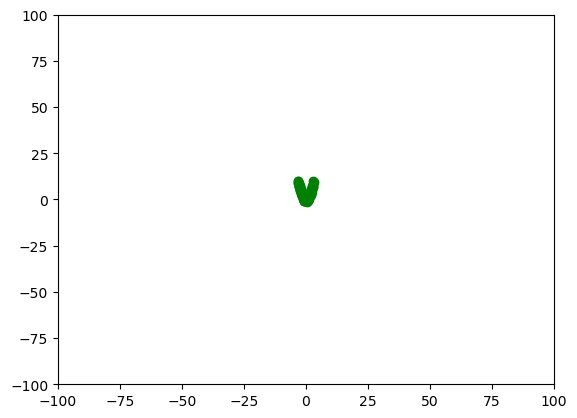

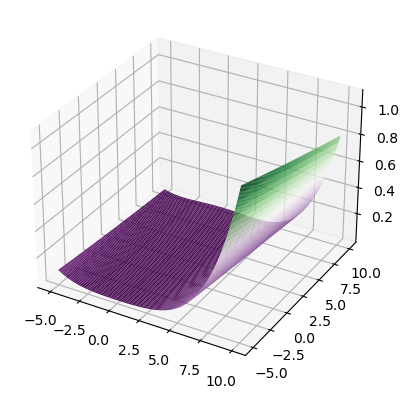

In [356]:
# Rosnebrock function (in 3D space for visualization)

results = cuckoo_search(
    function=rosenbrock_function,
    ranges=rosenbrock_function_range,
    dimensions_count=2,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    visualize=True)

plot_function(rosenbrock_function, rosenbrock_function_range)

In [364]:
# Lab results

# Sphere function
sphere_results = cuckoo_search(
    function=sphere_function,
    ranges=sphere_function_range,
    dimensions_count=50,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    max_generation=100_000)

print('Best result coordinatest for sphere function:', sphere_results[0])

Best result coordinatest for sphere function: [6.292535031116159, -24.485307535949616, -39.419908179896645, -68.77246666746773, -5.169400909580887, 49.400447825909026, -50.89304078593002, -29.213861441600812, 19.998950712027792, 2.992477977517453, -38.85085568813827, 53.26483715121043, 23.435388975943013, -24.565075336855216, -52.067266296917445, 38.226172261692, -37.0454905736068, 50.14056558279739, -60.902241060562986, -26.48440753171188, 43.71983499662798, 44.1506304457894, 48.117432278182406, -32.25845804824627, 0.6184066487603417, 53.493809926028064, -19.52809347300648, -46.073885649643984, 9.741206914057244, 34.971369140563155, 33.132522353578565, 76.31177770457634, 25.126331116635498, 60.23358471316402, -40.09706969288733, -2.2262636290550404, -16.324449159891728, -35.50173549512678, 41.69893793586613, 54.53913979845905, 2.7392879658047207, 35.921885278893996, -0.16845687156271083, -62.109104300206084, -37.36292032433954, 82.6899614770241, -21.763527000584148, -38.50586439595842

In [366]:
# Ackley function
ackley_results = cuckoo_search(
    function=ackley_function,
    ranges=ackley_function_range,
    dimensions_count=20,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    max_generation=100_000)

print('Best result coordinatest for ackley function:', ackley_results[0])

Best result coordinatest for ackley function: [-8.56163606573634, -8.495045485535819, 5.961359615630656, -8.868241570736355, -5.919392759277709, 9.818091739017163, 5.83402344729263, 1.7922562056985072, -5.906397823848238, 7.4482708983280475, 13.397765652923866, -6.689023578160786, -5.516713620300724, -8.196097475861716, -12.48931525758768, 0.28704253695921267, -14.296205278710048, 5.494012667751171, -10.805402861559603, 11.756555574798746]


In [367]:
# Griewank function
griewank_results = cuckoo_search(
    function=griewank_function,
    ranges=griewank_function_range,
    dimensions_count=50,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    max_generation=100_000)

print('Best result coordinatest for griewank function:', griewank_results[0])

Best result coordinatest for griewank function: [9.930322153008316, 0.8053946570603543, -6.129951882208005, -4.480792134519193, 2.2368722253141176, 4.536478899900345, 1.8750678215247873, 5.27255828013895, 0.4615244726453156, -0.6397537099331725, -1.664215404794696, 1.962376448941379, -1.1063928784113752, 0.46385812194570164, 1.3756873133380605, 4.250208569258964, 3.590711744011138, -5.389526665430511, -2.740934549884873, -4.144216935028487, -2.6100091593489916, 1.7974042833110389, 9.214593291545519, 0.3709280825558068, 2.209367562184001, -1.4269131288140091, -2.574447429598223, 0.09344937090054728, -1.0032972666817752, 3.95509540217045, 2.2099034530345456, 1.8880814674747093, -8.33616273821873, 6.9849863173394375, -2.867171532922259, -1.5341588694639245, 0.8591707012479972, 2.6336150461018253, -3.4349604637604685, 2.1803287561170333, 4.795289825666927, 6.086898280068546, 1.658729682420141, -6.447840266578552, 0.059791406498113986, 0.9824943111183373, 1.1740326381814938, 3.6611293111967

In [369]:
# Rastrigin function
rastrigin_results = cuckoo_search(
    function=rastrigin_function,
    ranges=rastrigin_function_range,
    dimensions_count=50,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    max_generation=100_000)

print('Best result coordinatest for rastrigin function:', rastrigin_results[0])

Best result coordinatest for rastrigin function: [-0.5884344866164373, 4.612776098620711, 2.864933728468613, 1.900671083476909, 1.8709527563565471, 3.089247283548965, 2.4027018673694567, -0.3188237039282322, 0.7006736804889462, -0.06936871644819931, -1.9798891659920752, -2.9384754527679036, -0.9201054828143516, 0.8709160610866107, -0.97910617549549, 3.5614956188563616, -2.9213852455978997, -3.9852722549623563, -3.400690201123721, 2.803046062150936, -4.00214451841916, -2.0894955351634676, 0.5983751465192633, -3.658312600580605, -1.8852582658524444, -3.4669427003631634, 2.9712568653077662, -2.003274179093817, -1.0106456358526783, -0.03914384192138076, 0.12995466023423585, -1.3442155973459036, 1.832693284079621, -1.7619904646076794, -1.0992633509653, 3.8511610919703587, -4.07568621753815, -1.4145667328950968, -4.26646743690642, -1.0041963883335203, 1.0140995228616365, -1.1973866331234988, -3.199948507186566, 1.1203133137604473, -5.114663344554343, -1.8799717309842903, -0.5525463308180543,

In [370]:
# Rosenbrock function
rosenbrock_results = cuckoo_search(
    function=rosenbrock_function,
    ranges=rosenbrock_function_range,
    dimensions_count=50,
    cuckoo_count=3,
    P_alpha=0.01,
    nest_count=100,
    max_generation=100_000)

print('Best result coordinatest for rosenbrock function:', rosenbrock_results[0])

Best result coordinatest for rosenbrock function: [2.3228072082998352, 3.63299069185185, -0.6707517402367138, 3.83224337907701, 0.8276471956035767, 7.095809420958297, 2.70834631670301, 0.3405618752164852, 0.9811965567977934, 5.537495306438007, -0.84908086773427, 0.7246971188735696, 3.0719360470256483, 4.382124656709063, 6.665720172172657, -0.6555147370571568, 0.44464014510176675, -0.6205329481320723, -4.871167633946963, 2.137455935635411, -1.3905141664019158, -1.575170218499145, -0.46037806301369866, 4.045307794242278, -3.9704361016143257, -1.5682674981130615, -1.2214024398231142, 1.6164100601067357, -2.9599710703060875, -4.895546360766607, 5.420911187808436, -3.832077675644174, -1.1671696232352833, 1.4076091300711138, 7.223522206531776, -4.12092096471784, 3.276206155614126, -0.2119475242900002, 4.298698457764242, -2.828639980856246, -4.815588975801823, -3.9760445483305458, 4.334933523925995, 0.12660662099016662, 4.244946762460071, -1.7808274121821692, 0.633756816890906, 1.689445200277